# Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

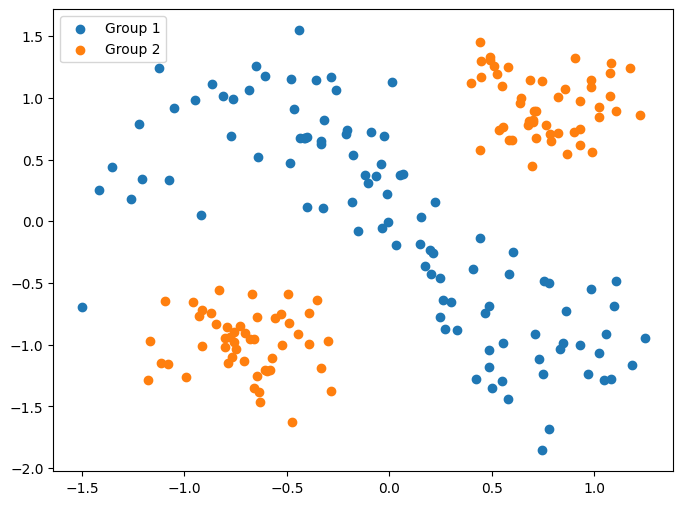

In [69]:
group1_x1 = np.random.normal(size=100, scale=0.75)
group1_x2 = group1_x1**3 - 2 * group1_x1 + np.random.normal(size=100, scale=0.4)
group1_y = np.zeros(100)

group2_scale = 0.25
group2_x1 = np.concatenate([np.random.normal(size=50, loc=0.75, scale=group2_scale), np.random.normal(size=50, loc=-0.75, scale=group2_scale)])
group2_x2 = np.concatenate([np.random.normal(size=50, loc=1, scale=group2_scale), np.random.normal(size=50, loc=-1, scale=group2_scale)])
group2_y = np.ones(100)

x1 = np.concatenate([group1_x1, group2_x1])
x2 = np.concatenate([group1_x2, group2_x2])

X = np.array([x1, x2]).T
y = np.concatenate([group1_y, group2_y])

plt.figure(figsize=(8, 6))
plt.scatter(X[y==0].T[0], X[y==0].T[1], label="Group 1")
plt.scatter(X[y==1].T[0], X[y==1].T[1], label="Group 2")
plt.legend()
plt.show()

# Model

Source:
- <a href="https://www.youtube.com/watch?v=ZVR2Way4nwQ">Normalized Nerd - Decision Tree Classification</a>
- <a href="https://www.youtube.com/watch?v=sgQAhG5Q7iY">Normalized Nerd - Decision Tree Classification in Python</a>
- <a href="https://www.youtube.com/watch?v=NxEHSAfFlK8">AssemblyAI</a>

In [88]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTreeClassification:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_left/n) * e_left + (n_right/n) * e_right

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y.astype("int64"))
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    def _most_common_label(self, y):
        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# Train

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

treeClf = DecisionTreeClassification()
treeClf.fit(X_train, y_train)

# Evaluation

In [91]:
from sklearn.metrics import accuracy_score

y_pred = treeClf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100}%")

Accuracy: 95.0%
